# Clasificador

## Lectura de Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from models import *
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import warnings
import shap
from sklearn.feature_selection import SelectFromModel
import prince
from src.selected_model import SVM_glioma

In [2]:
warnings.filterwarnings("ignore")

## Lectura de datos

In [3]:
data = pd.read_csv("data/TCGA_InfoWithGrade.csv")

In [4]:
data.shape

(839, 24)

## División set en entrenamiento y testeo

In [5]:
independent_variables = ['Gender', 'Age_at_diagnosis', 'Race', 'IDH1', 'TP53', 'ATRX',
       'PTEN', 'EGFR', 'CIC', 'MUC16', 'PIK3CA', 'NF1', 'PIK3R1', 'FUBP1',
       'RB1', 'NOTCH1', 'BCOR', 'CSMD3', 'SMARCA4', 'GRIN2A', 'IDH2', 'FAT4',
       'PDGFRA']
categorical_variables = ['Race']
continous_vars =['Age_at_diagnosis']
target_variable = 'Grade'
test_size = 0.3

In [6]:
X_train, X_test, y_train, y_test = train_test(data,independent_variables,target_variable,categorical_variables,test_size)

## Reducción de la dimensionalidad

Analisis de los componentes principales

In [7]:
# instantiate MCA class
mca = prince.MCA(one_hot=True, n_components=25)
mca_cols = ['Grade', 'Gender','Race', 'IDH1', 'TP53', 'ATRX',
       'PTEN', 'EGFR', 'CIC', 'MUC16', 'PIK3CA', 'NF1', 'PIK3R1', 'FUBP1',
       'RB1', 'NOTCH1', 'BCOR', 'CSMD3', 'SMARCA4', 'GRIN2A', 'IDH2', 'FAT4',
       'PDGFRA']
# get principal components
mca_model = mca.fit(data[mca_cols])
print(mca_model.eigenvalues_summary)

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.129        11.83%                     11.83%
1              0.088         8.13%                     19.96%
2              0.076         7.04%                     26.99%
3              0.051         4.68%                     31.67%
4              0.051         4.65%                     36.32%
5              0.050         4.57%                     40.89%
6              0.046         4.27%                     45.15%
7              0.045         4.15%                     49.30%
8              0.044         4.07%                     53.37%
9              0.044         4.02%                     57.39%
10             0.043         3.94%                     61.33%
11             0.042         3.87%                     65.20%
12             0.041         3.76%                     68.96%
13             0.039         3.58%                     72.54%
14      

Selección de variables con el selectKbest

Feature 0: 0.416778
Feature 1: 109.108539
Feature 2: 9.052664
Feature 3: 149.444117
Feature 4: 7.122920
Feature 5: 46.129870
Feature 6: 58.843075
Feature 7: 23.636186
Feature 8: 42.904950
Feature 9: 15.858417
Feature 10: 1.512236
Feature 11: 3.502883
Feature 12: 3.249927
Feature 13: 16.130476
Feature 14: 24.348870
Feature 15: 19.365994
Feature 16: 0.186150
Feature 17: 2.274261
Feature 18: 4.368450
Feature 19: 15.769357
Feature 20: 5.334081
Feature 21: 0.549904
Feature 22: 10.285570


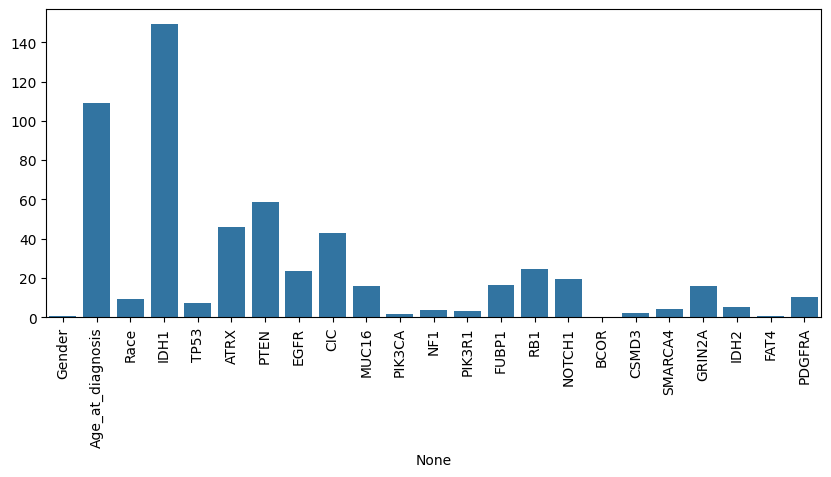

In [8]:
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, 20)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
plt.figure(figsize=(10,4))
sns.barplot(x=X_train.columns, y=fs.scores_)
plt.xticks(rotation = 90)
plt.show()

Seleccion con Random Forest

In [9]:
sel = SelectFromModel(RandomForestClassifier(**{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100, 'oob_score': True}))
sel.fit(X_train, y_train)
sel.get_support()
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)

5

In [10]:
selected_feat

Index(['Age_at_diagnosis', 'IDH1', 'ATRX', 'PTEN', 'CIC'], dtype='object')

### KNN

{'n_neighbors': 15, 'weights': 'uniform'}


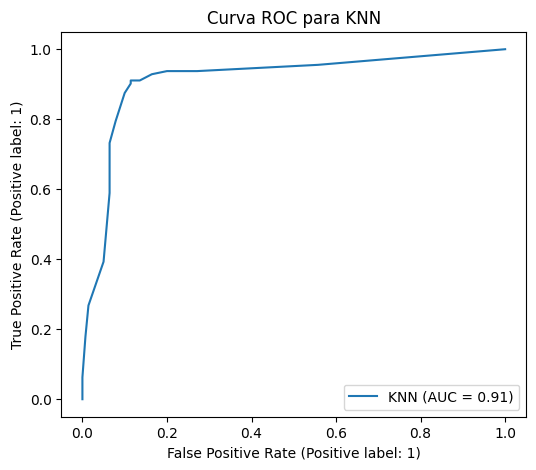

0.8888888888888888 0.875 0.875 0.875 0.8875


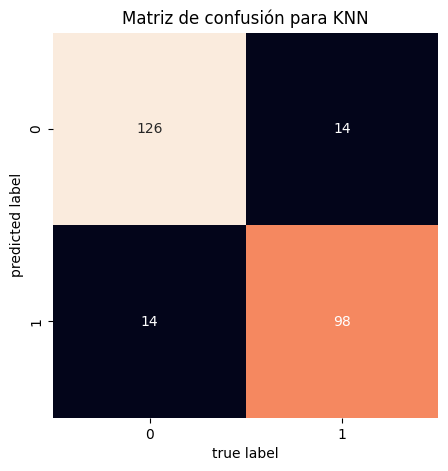

In [12]:
knn_model_1, knn_eval, roc_auc_knn, fpr_knn, tpr_knn = knn_model(X_train, y_train, X_test, y_test, continous_vars, categorical_variables)

{'n_neighbors': 19, 'weights': 'uniform'}


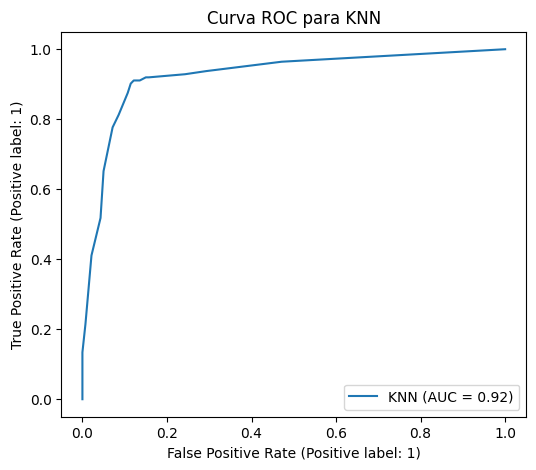

0.8849206349206349 0.8672566371681416 0.875 0.8711111111111112 0.8839285714285715
{'n_neighbors': 20, 'weights': 'uniform'}


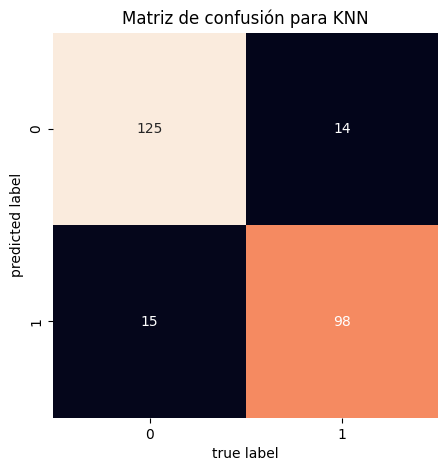

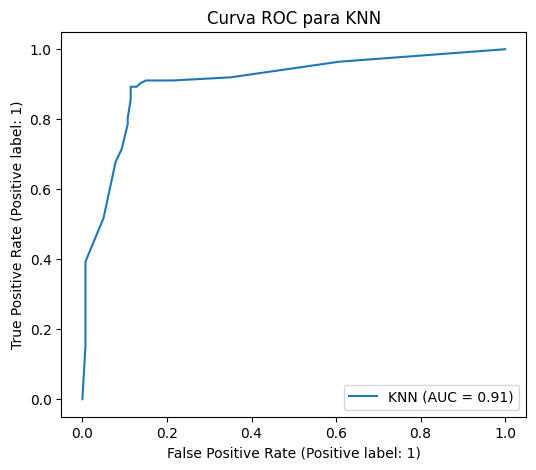

0.8531746031746031 0.8571428571428571 0.8035714285714286 0.8294930875576038 0.8482142857142857


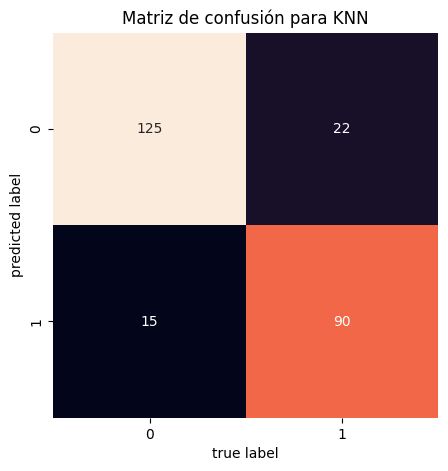

In [13]:
knn_model_2, knn_eval_2, roc_auc_knn_2, fpr_knn_2, tpr_knn_2 = knn_model(X_train_fs, y_train, X_test_fs, y_test, continous_vars, categorical_variables)
knn_model_3, knn_eval_3, roc_auc_knn_3, fpr_knn_3, tpr_knn_3 = knn_model(X_train[selected_feat], y_train, X_test[selected_feat], y_test, continous_vars, [])

### SVM

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


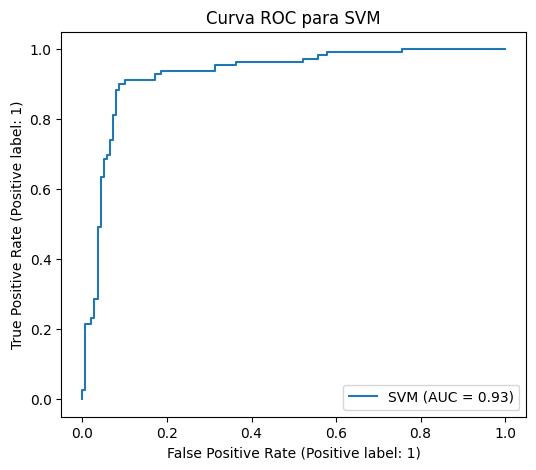

0.9047619047619048 0.8793103448275862 0.9107142857142857 0.8947368421052632 0.9053571428571427
{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


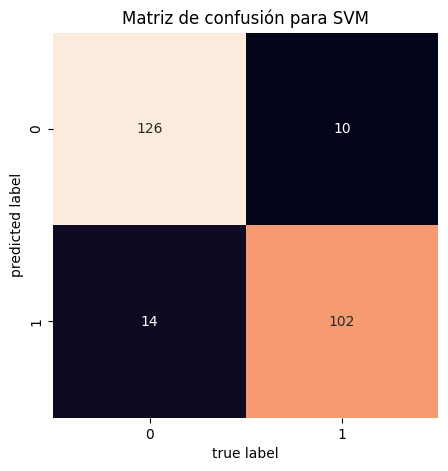

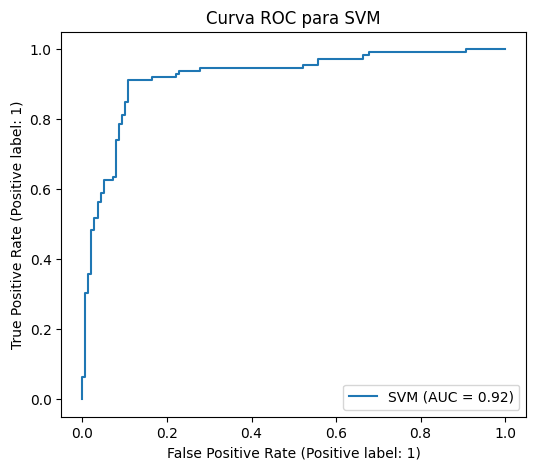

0.9007936507936508 0.8717948717948718 0.9107142857142857 0.8908296943231441 0.9017857142857143


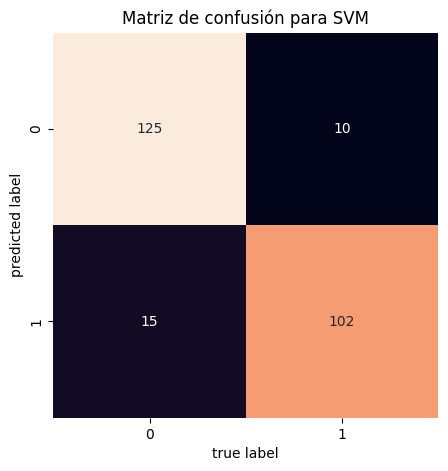

In [11]:
svm_model_1, svm_eval, roc_auc_svm,fpr_svm, tpr_svm = svm_model(X_train, y_train, X_test, y_test, continous_vars, categorical_variables)
svm_model_2, svm_eval_2, roc_auc_svm_2,fpr_svm_2, tpr_svm_2 = svm_model(X_train_fs, y_train, X_test_fs, y_test, continous_vars, categorical_variables,'_chi-cuadrado')
svm_model_3, svm_eval_3, roc_auc_svm_3,fpr_svm_3, tpr_svm_3 = svm_model(X_train[selected_feat], y_train, X_test[selected_feat], y_test, continous_vars, [],'_reduced')

### Random Forest

{'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100, 'oob_score': True}


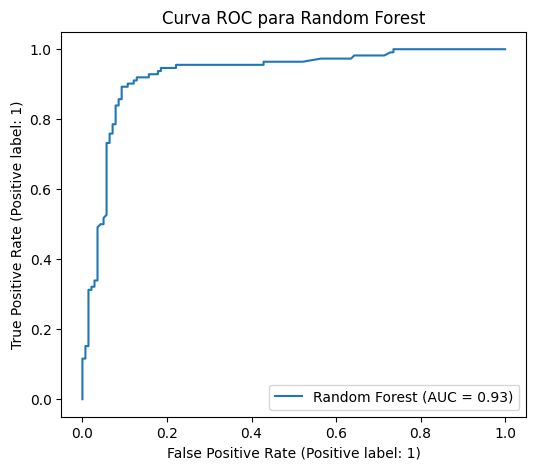

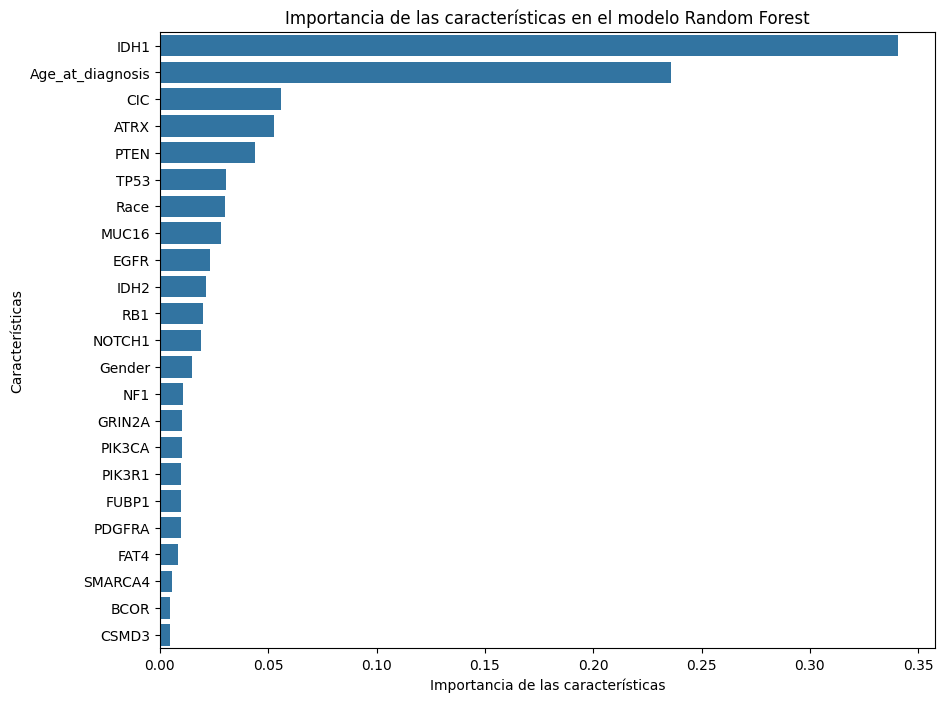

0.8888888888888888 0.8818181818181818 0.8660714285714286 0.8738738738738738 0.8866071428571429
{'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100, 'oob_score': True}


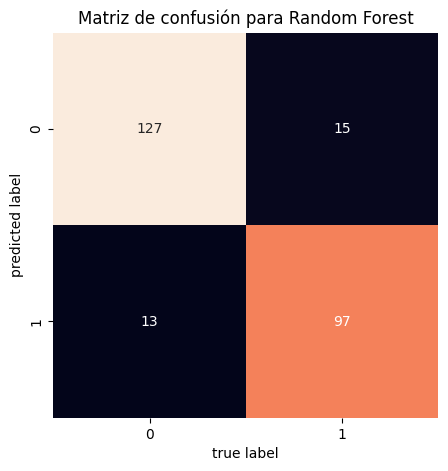

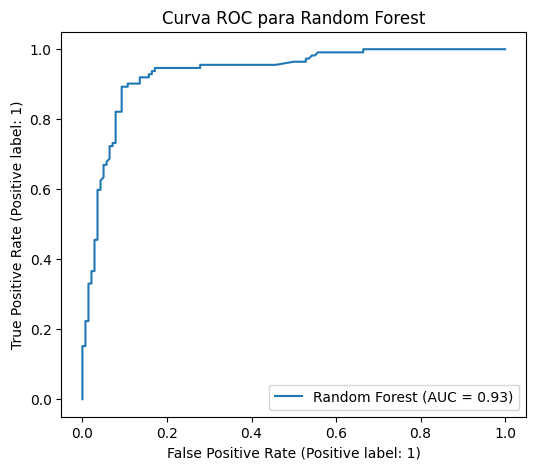

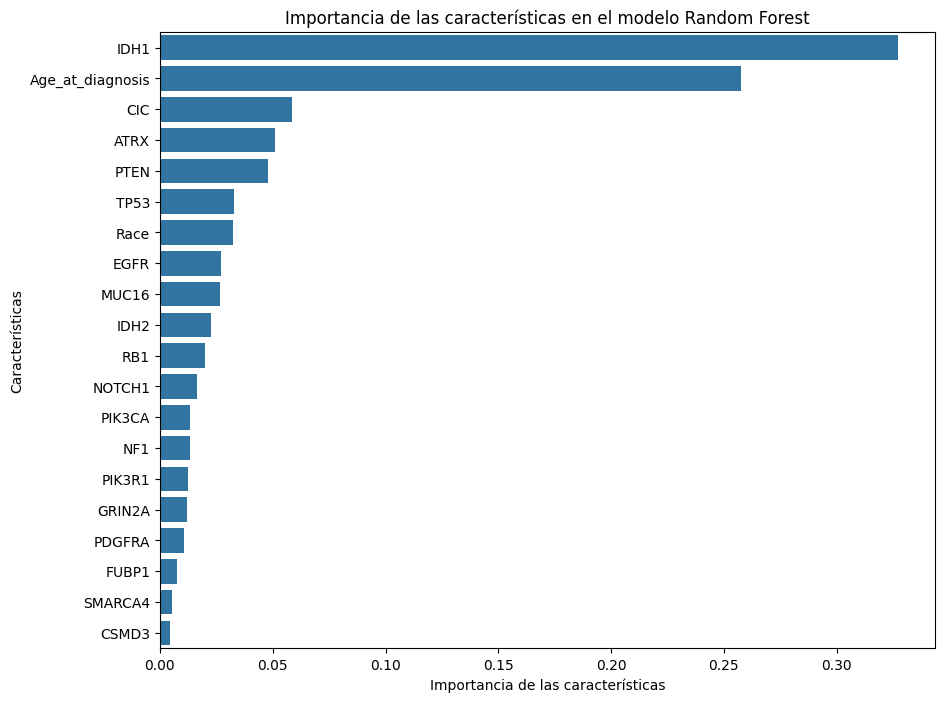

0.8928571428571429 0.8828828828828829 0.875 0.8789237668161436 0.8910714285714286
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100, 'oob_score': True}


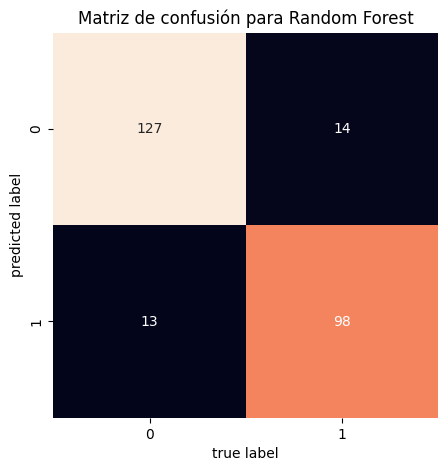

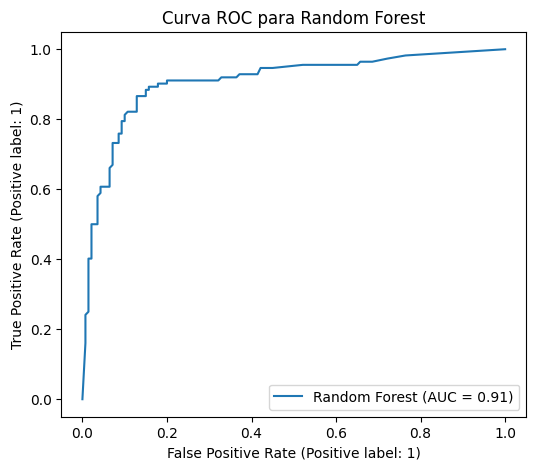

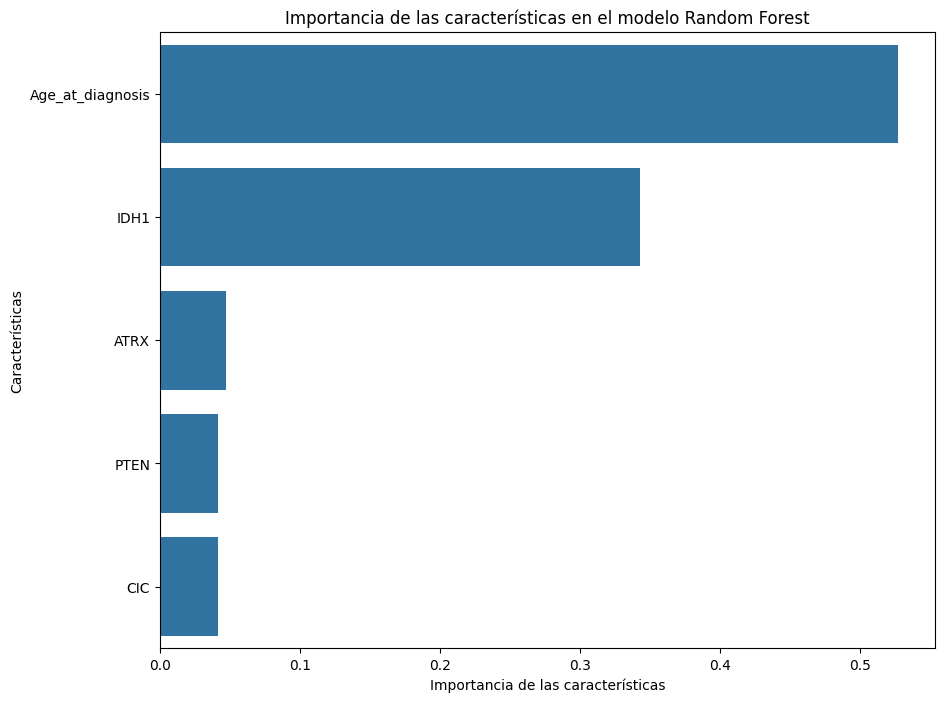

0.8571428571428571 0.8392857142857143 0.8392857142857143 0.8392857142857143 0.8553571428571429


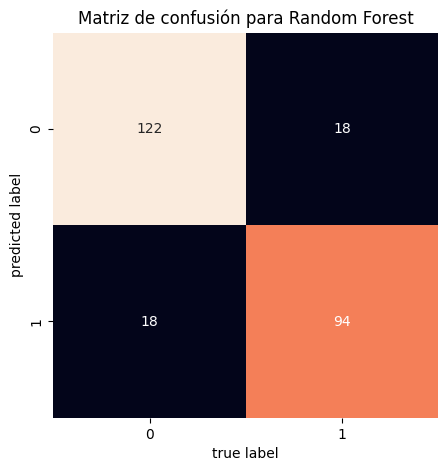

In [15]:
rf_model_1,rf_eval, roc_auc_fr,fpr_rf, tpr_rf = random_forest(X_train, y_train, X_test, y_test, continous_vars, categorical_variables)
rf_model_2,rf_eval_2, roc_auc_fr_2,fpr_rf_2, tpr_rf_2 = random_forest(X_train_fs, y_train, X_test_fs, y_test, continous_vars, categorical_variables)
rf_model_3,rf_eval_3, roc_auc_fr_3,fpr_rf_3, tpr_rf_3 = random_forest(X_train[selected_feat], y_train, X_test[selected_feat], y_test, continous_vars, categorical_variables)

### Gradient Boosting

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


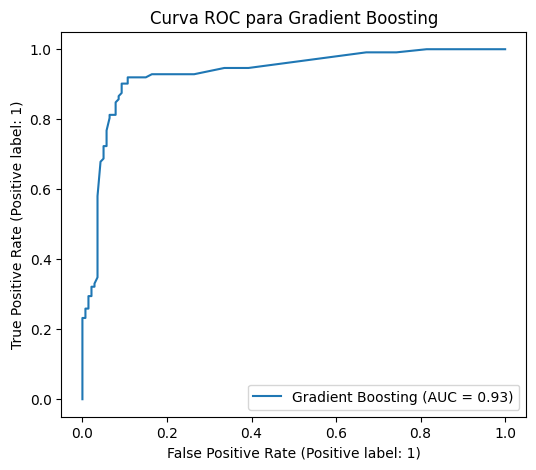

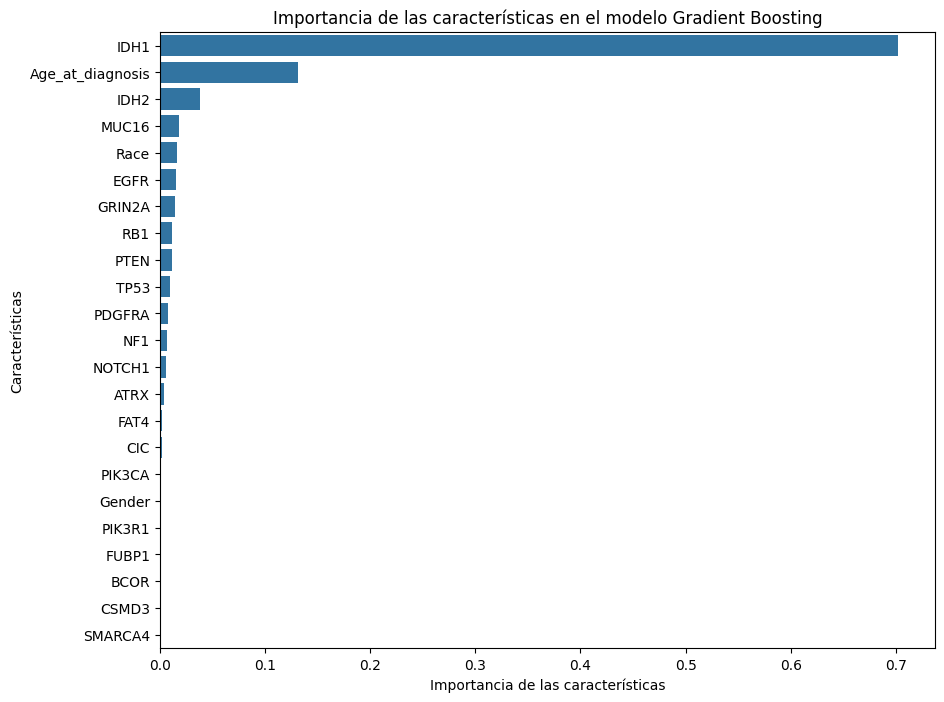

0.8888888888888888 0.8888888888888888 0.8571428571428571 0.8727272727272727 0.8857142857142857
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


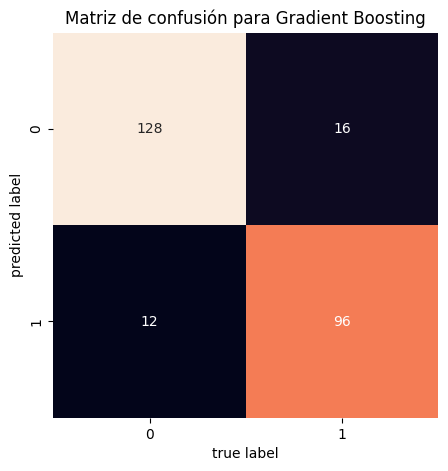

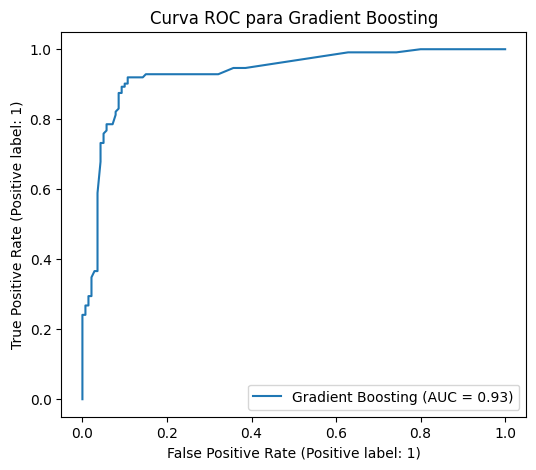

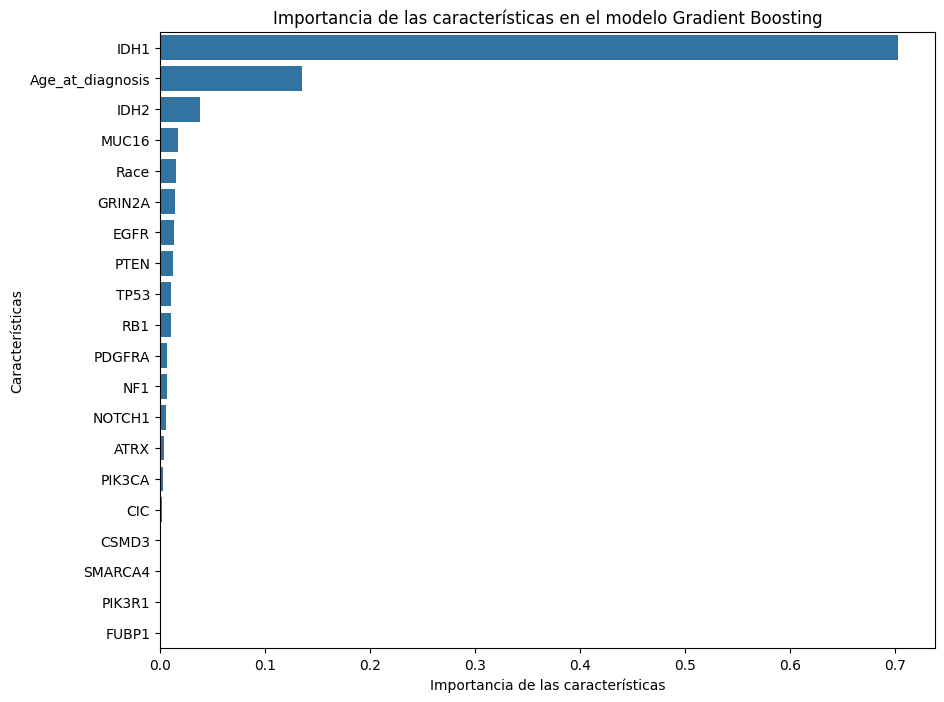

0.876984126984127 0.8932038834951457 0.8214285714285714 0.8558139534883721 0.8714285714285714
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


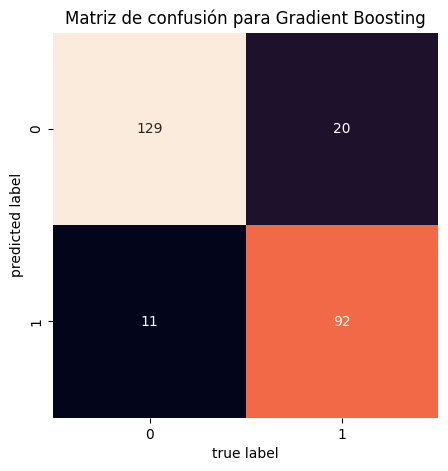

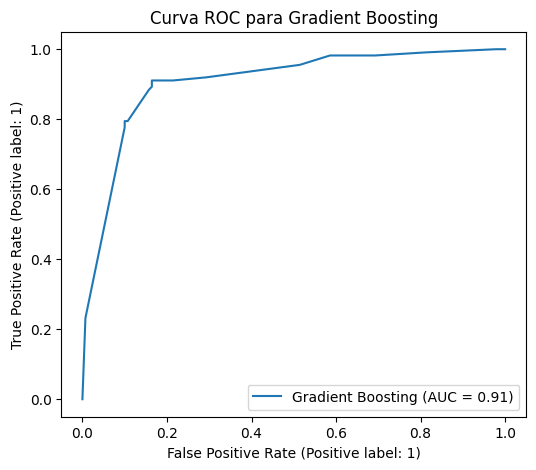

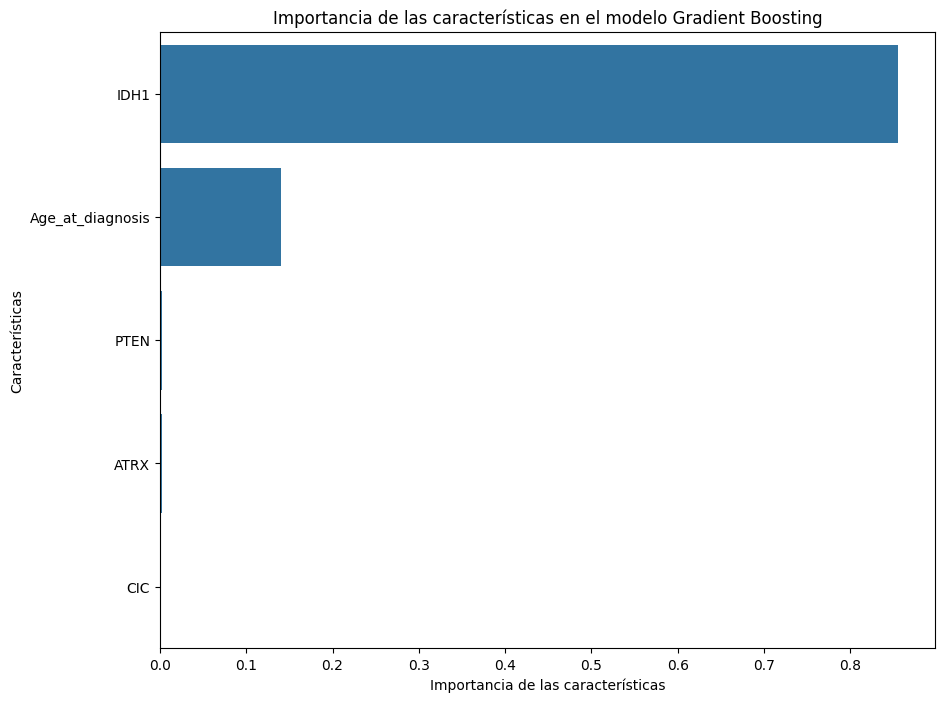

0.8452380952380952 0.8613861386138614 0.7767857142857143 0.8169014084507042 0.8383928571428573


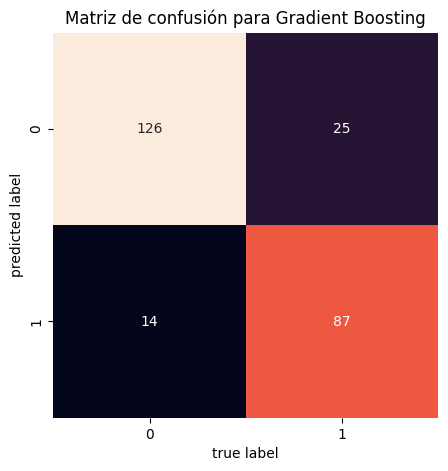

In [16]:
xgb_model_1, xgb_eval,roc_auc_xgb, fpr_xgb, tpr_xgb = gradient_boosting(X_train, y_train, X_test, y_test)
xgb_model_2, xgb_eval_2,roc_auc_xgb_2, fpr_xgb_2, tpr_xgb_2 = gradient_boosting(X_train_fs, y_train, X_test_fs, y_test)
xgb_model_3, xgb_eval_3,roc_auc_xgb_3, fpr_xgb_3, tpr_xgb_3 = gradient_boosting(X_train[selected_feat], y_train, X_test[selected_feat], y_test)

### Regresión Logística

{'C': 1, 'solver': 'lbfgs', 'tol': 0.001, 'penalty': 'l2', 'class_weight': 'balanced'}


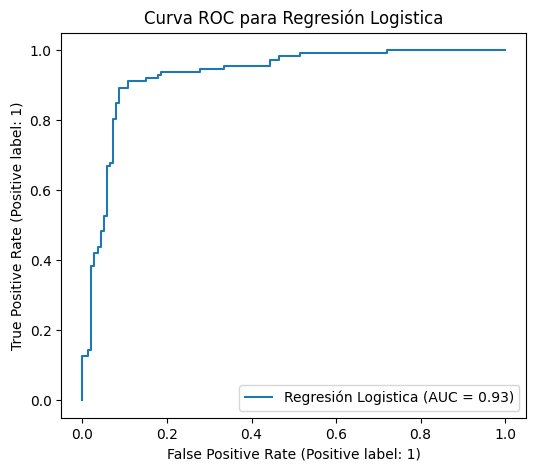

0.9007936507936508 0.8849557522123894 0.8928571428571429 0.8888888888888891 0.9
{'C': 1, 'solver': 'lbfgs', 'tol': 0.001, 'penalty': 'l2', 'class_weight': 'balanced'}


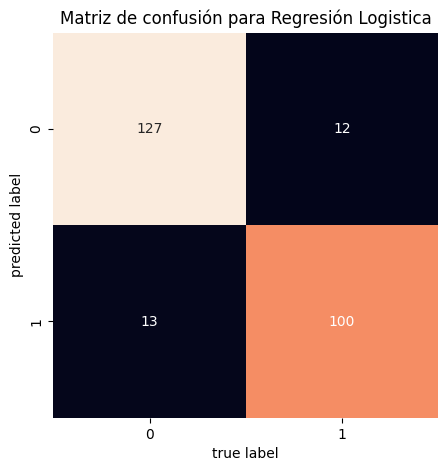

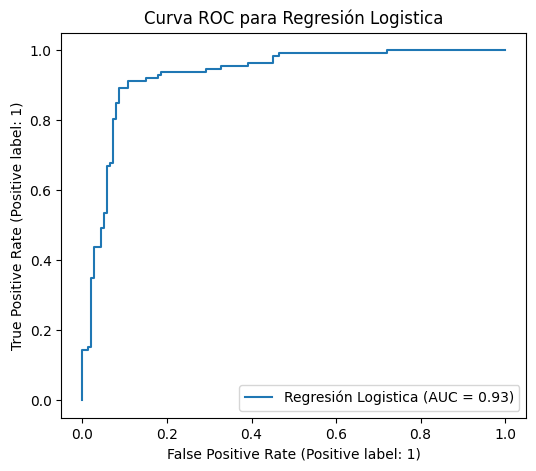

0.9007936507936508 0.8849557522123894 0.8928571428571429 0.8888888888888891 0.9
{'C': 0.1, 'solver': 'lbfgs', 'tol': 0.001, 'penalty': 'l2', 'class_weight': 'balanced'}


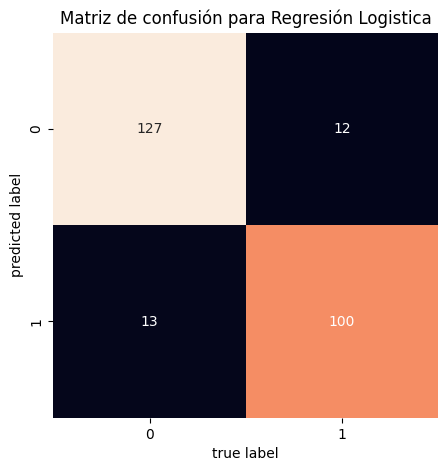

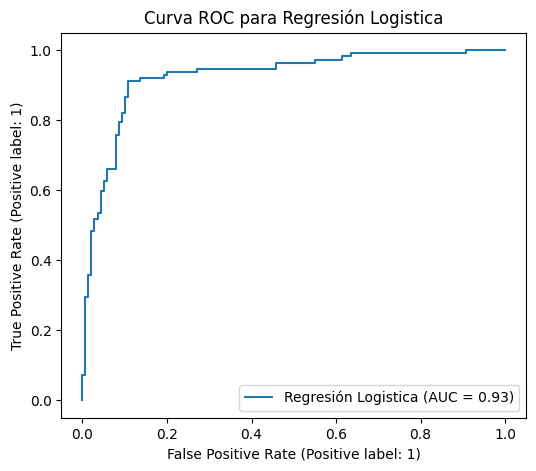

0.8968253968253969 0.8706896551724138 0.9017857142857143 0.8859649122807018 0.8973214285714287


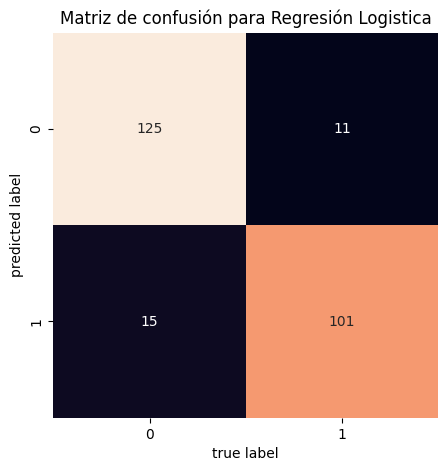

In [17]:
log_model, lr_eval, roc_auc_lr,fpr_lr, tpr_lr = logistic_model(X_train, y_train, X_test, y_test, continous_vars, categorical_variables)
log_model_2, lr_eval_2, roc_auc_lr_2,fpr_lr_2, tpr_lr_2= logistic_model(X_train_fs, y_train, X_test_fs, y_test, continous_vars, categorical_variables)
log_model_3, lr_eval_3, roc_auc_lr_3,fpr_lr_3, tpr_lr_3= logistic_model(X_train[selected_feat], y_train, X_test[selected_feat], y_test, continous_vars, [])

<BarContainer object of 26 artists>

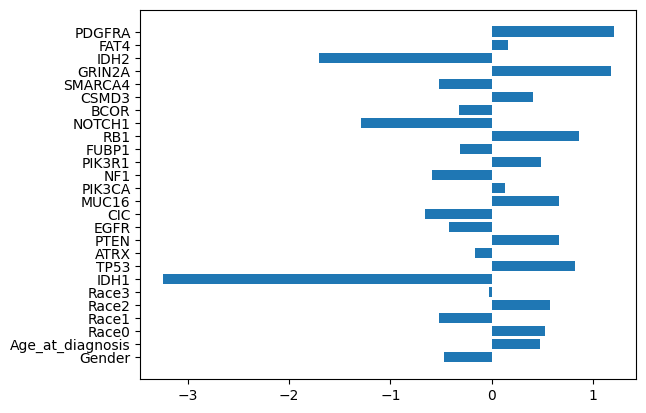

In [18]:
columns = ['Gender', 'Age_at_diagnosis', 'Race0','Race1','Race2','Race3', 'IDH1', 'TP53', 'ATRX', 'PTEN',
       'EGFR', 'CIC', 'MUC16', 'PIK3CA', 'NF1', 'PIK3R1', 'FUBP1', 'RB1',
       'NOTCH1', 'BCOR', 'CSMD3', 'SMARCA4', 'GRIN2A', 'IDH2', 'FAT4',
       'PDGFRA']
plt.barh(columns, svm_model_1.coef_.flatten())

## Comparación de modelos

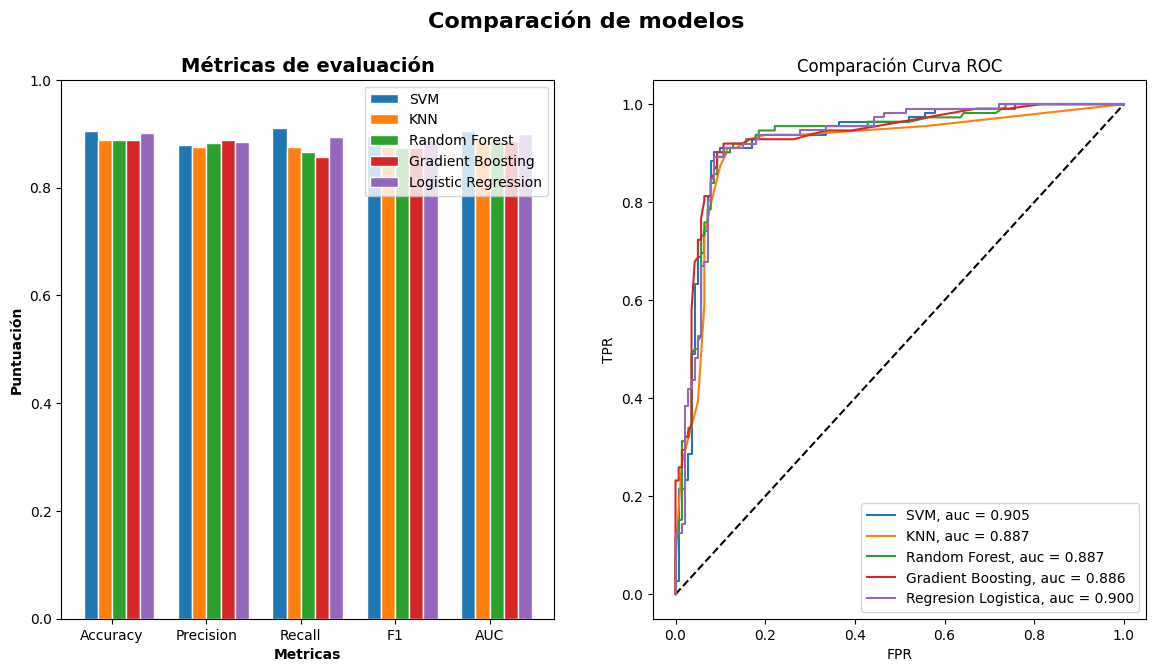

In [19]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Comparación de modelos', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.15
svm_score = [svm_eval['acc'], svm_eval['prec'], svm_eval['rec'], svm_eval['f1'], svm_eval['auc']]
knn_score = [knn_eval['acc'], knn_eval['prec'], knn_eval['rec'], knn_eval['f1'], knn_eval['auc']]
rf_score = [rf_eval['acc'], rf_eval['prec'], rf_eval['rec'], rf_eval['f1'], rf_eval['auc']]
xgb_score = [xgb_eval['acc'], xgb_eval['prec'], xgb_eval['rec'], xgb_eval['f1'], xgb_eval['auc']]
lr_score = [lr_eval['acc'], lr_eval['prec'], lr_eval['rec'], lr_eval['f1'], lr_eval['auc']]

## Set position of bar on X axis
r1 = np.arange(len(svm_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

## Make the plot
ax1.bar(r1, svm_score, width=barWidth, edgecolor='white', label='SVM')
ax1.bar(r2, knn_score, width=barWidth, edgecolor='white', label='KNN')
ax1.bar(r3, rf_score, width=barWidth, edgecolor='white', label='Random Forest')
ax1.bar(r4, xgb_score, width=barWidth, edgecolor='white', label='Gradient Boosting')
ax1.bar(r5, lr_score, width=barWidth, edgecolor='white', label='Logistic Regression')

## Configure x and y axis
ax1.set_xlabel('Metricas', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(svm_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Puntuación', fontweight='bold')
ax1.set_ylim(0, 1)

## Create legend & title
ax1.set_title('Métricas de evaluación', fontsize=14, fontweight='bold')
ax1.legend()


# Second plot
ax2.plot([0,1],[0,1], 'k--')
ax2.plot(fpr_svm, tpr_svm, label='SVM, auc = {:0.3f}'.format(svm_eval['auc']))
ax2.plot(fpr_knn, tpr_knn, label='KNN, auc = {:0.3f}'.format(knn_eval['auc']))
ax2.plot(fpr_rf, tpr_rf, label='Random Forest, auc = {:0.3f}'.format(rf_eval['auc']))
ax2.plot(fpr_xgb, tpr_xgb, label='Gradient Boosting, auc = {:0.3f}'.format(xgb_eval['auc']))
ax2.plot(fpr_lr, tpr_lr, label='Regresion Logistica, auc = {:0.3f}'.format(lr_eval['auc']))
ax2.legend()
ax2.set_xlabel("FPR")
ax2.set_ylabel("TPR")
plt.title('Comparación Curva ROC')
plt.show()

In [44]:
metrics = [svm_eval, knn_eval,rf_eval,xgb_eval,lr_eval]
df_metrics = pd.DataFrame.from_dict(metrics)
df_metrics.index = ["SVM","KNN","Random Forest","Gradient Boosting","Regresión Logistica"]
df_metrics.round(2)

,acc,prec,rec,f1,auc,cm
SVM,0.90,0.88,0.91,0.89,0.91,"[[126, 14], [10, 102]]"
KNN,0.89,0.88,0.88,0.88,0.89,"[[126, 14], [14, 98]]"
Random Forest,0.89,0.88,0.87,0.87,0.89,"[[127, 13], [15, 97]]"
Gradient Boosting,0.89,0.89,0.86,0.87,0.89,"[[128, 12], [16, 96]]"
Regresión Logistica,0.90,0.88,0.89,0.89,0.90,"[[127, 13], [12, 100]]"


In [21]:
metrics_reduced = [svm_eval, svm_eval_2,svm_eval_3,lr_eval,lr_eval_2,lr_eval_3]
df_metrics_reduced = pd.DataFrame.from_dict(metrics_reduced)
df_metrics_reduced.index = ["SVM","SVM escenario 2","SVM escenario 3","RL","RL escenario 2","RL escenario 3"]
df_metrics_reduced

,acc,prec,rec,f1,auc,cm
SVM,0.904762,0.879310,0.910714,0.894737,0.905357,"[[126, 14], [10, 102]]"
SVM escenario 2,0.900794,0.871795,0.910714,0.890830,0.901786,"[[125, 15], [10, 102]]"
SVM escenario 3,0.900794,0.871795,0.910714,0.890830,0.901786,"[[125, 15], [10, 102]]"
RL,0.900794,0.884956,0.892857,0.888889,0.900000,"[[127, 13], [12, 100]]"
RL escenario 2,0.900794,0.884956,0.892857,0.888889,0.900000,"[[127, 13], [12, 100]]"
RL escenario 3,0.896825,0.870690,0.901786,0.885965,0.897321,"[[125, 15], [11, 101]]"


## Explicabilidad de los modelos usando shap values

MODELO SVM

In [22]:
encoder = pickle.load(open('models/encoder.pickle', 'rb'))
X_train_trf = encoder.transform(X_train)
X_test_trf = encoder.transform(X_test)

In [33]:
X_train_summary = shap.kmeans(X_train_trf, 20)
explainer =shap.KernelExplainer(svm_model_1.predict_proba, X_train_summary, link='logit')
shap_values = explainer.shap_values(X_test_trf)

  0%|          | 0/252 [00:00<?, ?it/s]

In [24]:
df =  pd.DataFrame(X_test_trf,columns = [x.split("__")[-1] for x in full_pipeline.get_feature_names_out()])

In [47]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

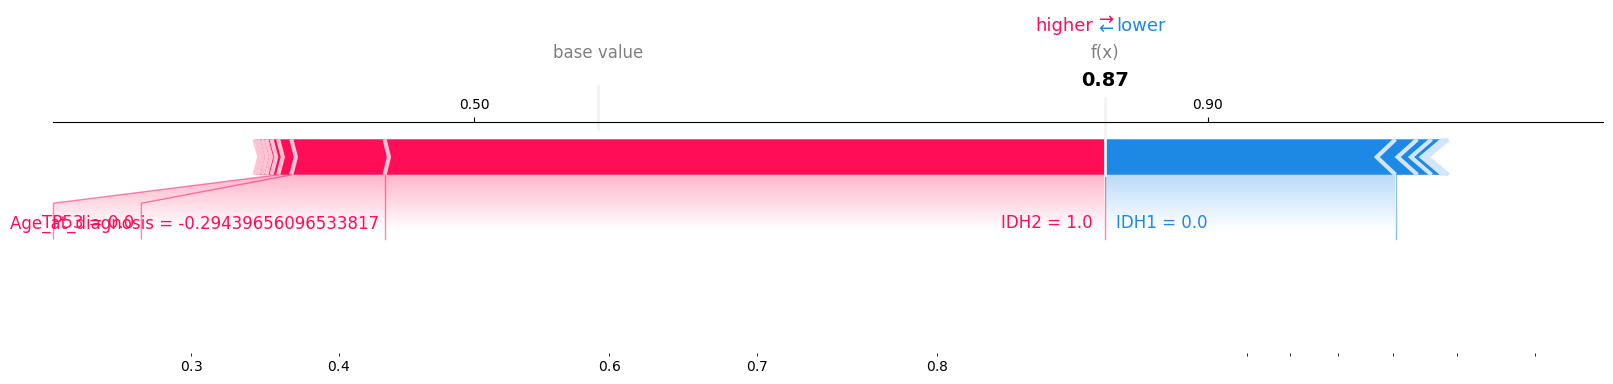

In [51]:
shap.force_plot(explainer.expected_value[0], shap_values[0][3,:], df.iloc[3,:], link="logit",matplotlib=True)

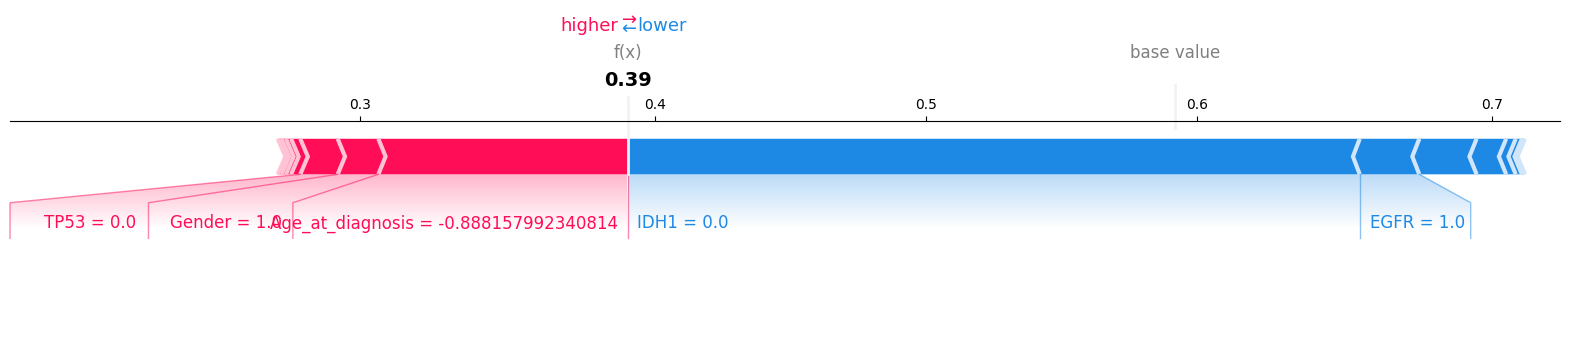

In [27]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:],  df.iloc[0,:], link="logit",matplotlib=True)

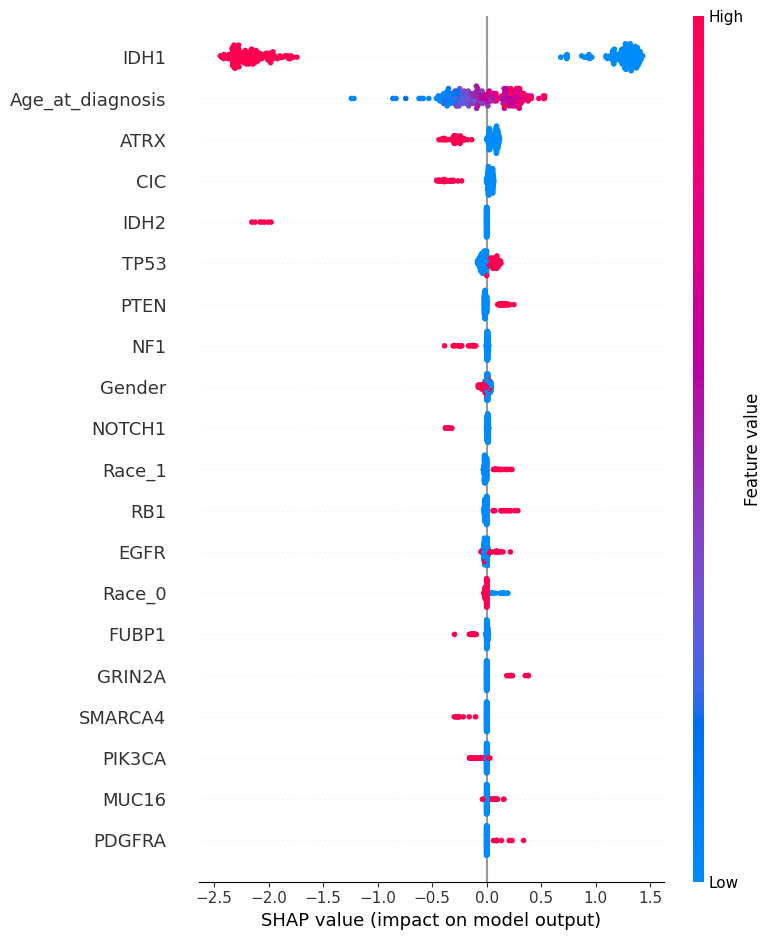

In [61]:
shap.summary_plot(shap_values[1], df)

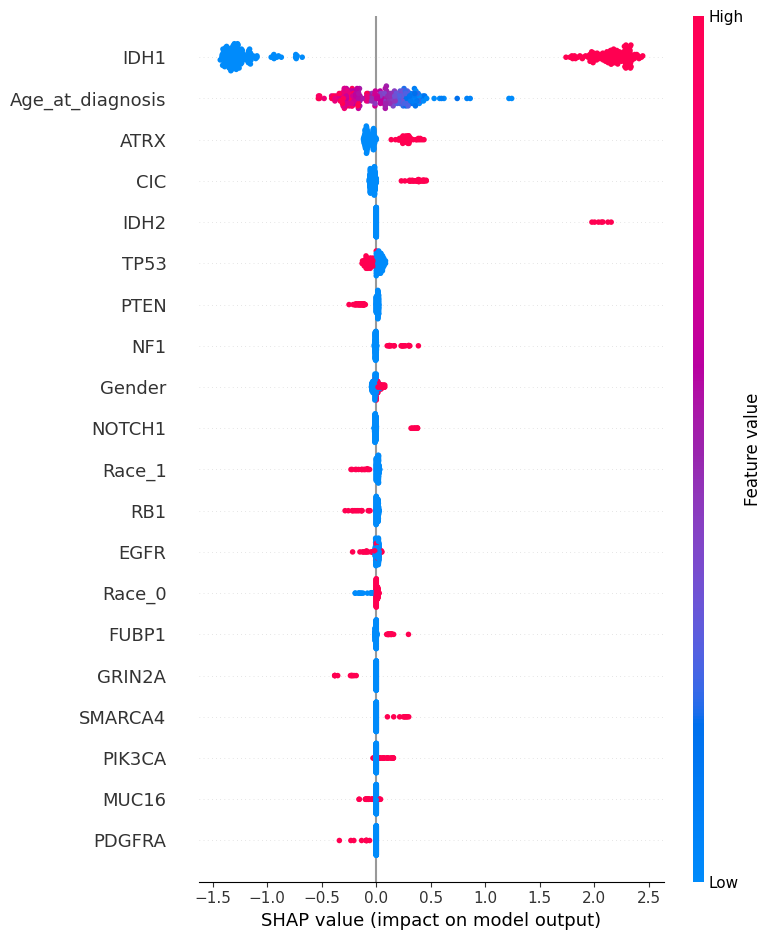

In [35]:
shap.summary_plot(shap_values[0], df,show=False)
plt.savefig("models/shap_summary.svg",dpi=700)

MODELO REGRESION LOGISTICA

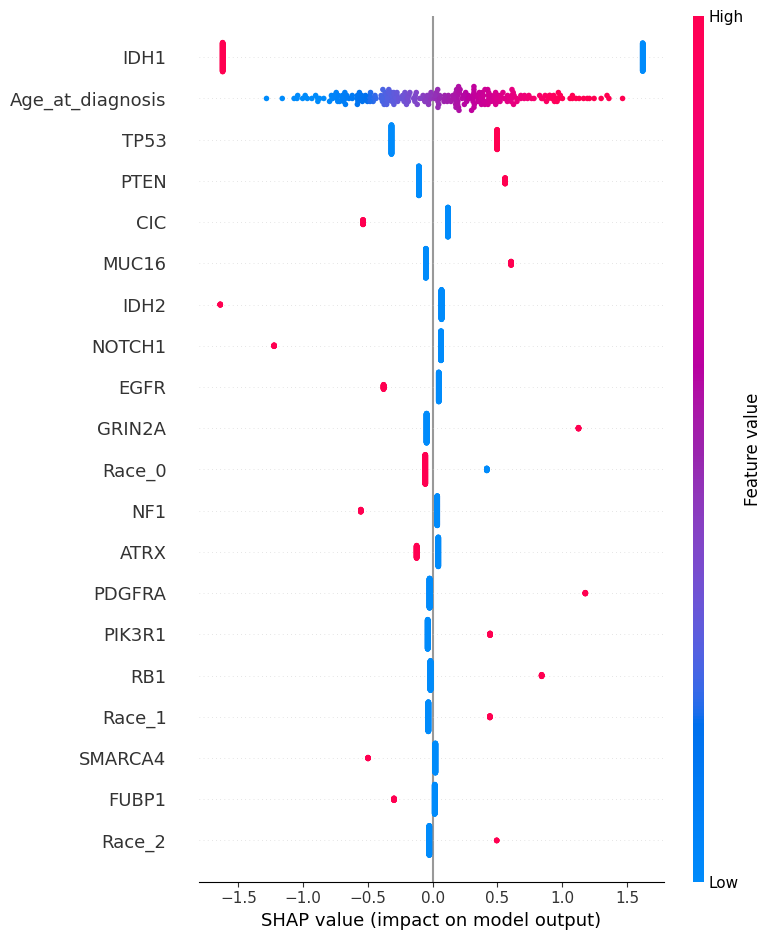

In [29]:
explainer2 = shap.LinearExplainer(log_model, X_train_trf)
shap_values_log = explainer2.shap_values(X_test_trf)
shap.summary_plot(shap_values_log, df)

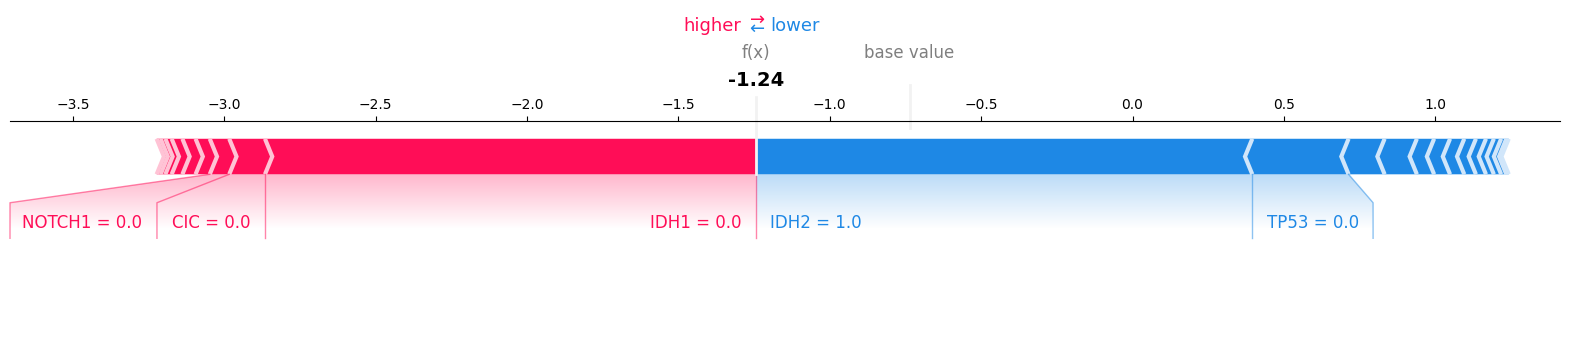

In [30]:
shap.force_plot(explainer2.expected_value, shap_values_log[3,:], df.iloc[3,:], matplotlib=True)

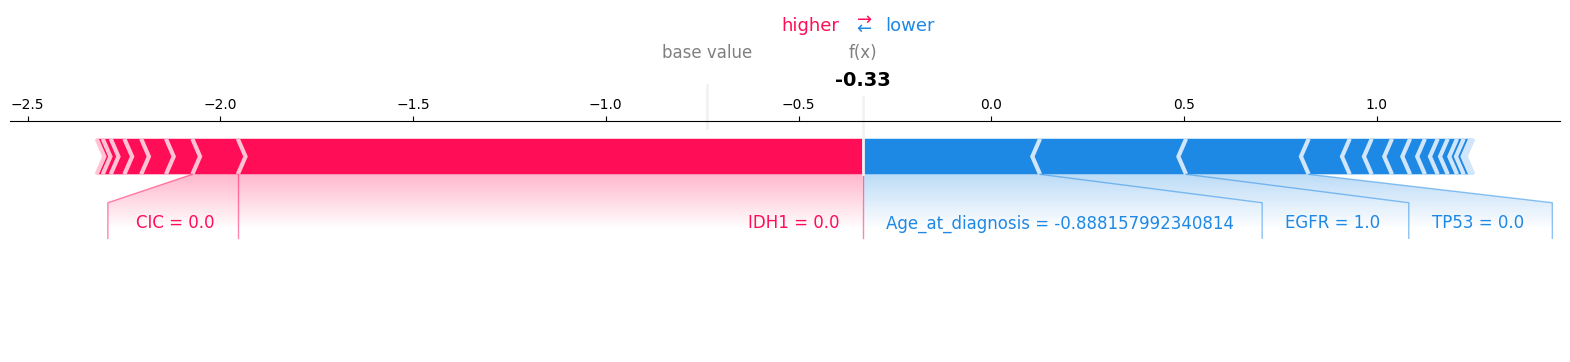

In [31]:
shap.force_plot(explainer2.expected_value, shap_values_log[0,:], df.iloc[0,:], matplotlib=True)